In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=7a74485c5222f0dc2f540fd69ef1b79a3d5ac0dbf7409451ee4846b2c9cab5ff
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras import Input
from keras.losses import categorical_crossentropy
from keras.callbacks import Callback
from keras.optimizers import SGD
from itertools import cycle
from neuralnet import NeuralNetMLP, int_to_onehot, train
from MLP_2layers import NeuralNetMLP_2layers, int_to_onehot
%matplotlib inline

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# obtain and prepare the MNIST dataset

In [4]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values
X, y = shuffle(X, y, random_state=33)

print(X.shape)
print(y.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


check class diatribution

In [5]:
for i in range(0, 10):
  print(f"{i}: {(y == i).sum()} / {len(y)}")

0: 6903 / 70000
1: 7877 / 70000
2: 6990 / 70000
3: 7141 / 70000
4: 6824 / 70000
5: 6313 / 70000
6: 6876 / 70000
7: 7293 / 70000
8: 6825 / 70000
9: 6958 / 70000


normalize to [-1, 1] range

In [6]:
X = ((X / 255.) - .5) * 2

split into train and test set

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=123, stratify=y)

In [8]:
del X, y

# utils methods

In [9]:
def plot_loss(loss_per_epoch, train_or_test="Train"):
  plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
  plt.ylabel(f'{train_or_test} Loss')
  plt.xlabel('Epoch')
  wandb.run.summary[f"{train_or_test} loss"] = loss_per_epoch[-1]
  wandb.log({f"{train_or_test} loss plot": plt})

In [10]:
def plot_accuracy(acc_per_epoch, train_or_test="Train"):
  plt.plot(range(len(acc_per_epoch)), acc_per_epoch)
  plt.ylabel(f'{train_or_test} Accuracy')
  plt.xlabel('Epochs')
  wandb.run.summary[f"{train_or_test} accuracy"] = acc_per_epoch[-1]
  wandb.log({f"{train_or_test} accuracy plot": plt})

In [11]:
def log_test_loss_acc(y_test, probas):
  onehot_y_test = int_to_onehot(y_test, num_labels=10)
  test_loss = categorical_crossentropy(onehot_y_test, probas).numpy().mean()
  wandb.run.summary["test loss"] = test_loss
  print(f'test loss: {test_loss:.2f}')

  test_pred = np.argmax(probas, axis=1)
  correct_pred = (test_pred == y_test).sum()
  test_acc = correct_pred/(y_test.shape[0])
  wandb.run.summary["test accuracy"] = test_acc
  print(f'test accuracy: {test_acc*100:.2f}%')

# eval MLP with 1 hidden layer

## train

In [12]:
run = wandb.init(
    project="HW3 part 1",
    name="1 layer MLP",
    config={"num_hidden": 400})

wandb: Currently logged in as: neyema. Use `wandb login --relogin` to force relogin


In [13]:
model = NeuralNetMLP(num_features=28*28, num_hidden=400, num_classes=10)
epoch_train_acc, epoch_train_loss, epoch_test_acc, epoch_test_loss = \
                                train(model, X_train, y_train, X_test, y_test)

Epoch: 001/050 | Train Loss: 0.71 | Train Acc: 86.64%  | Test Loss: 0.72 | Test Acc: 86.50% 
Epoch: 002/050 | Train Loss: 0.56 | Train Acc: 88.90%  | Test Loss: 0.56 | Test Acc: 88.90% 
Epoch: 003/050 | Train Loss: 0.49 | Train Acc: 90.17%  | Test Loss: 0.50 | Test Acc: 90.07% 
Epoch: 004/050 | Train Loss: 0.46 | Train Acc: 90.83%  | Test Loss: 0.47 | Test Acc: 90.71% 
Epoch: 005/050 | Train Loss: 0.42 | Train Acc: 91.36%  | Test Loss: 0.43 | Test Acc: 91.17% 
Epoch: 006/050 | Train Loss: 0.39 | Train Acc: 91.83%  | Test Loss: 0.41 | Test Acc: 91.58% 
Epoch: 007/050 | Train Loss: 0.38 | Train Acc: 92.07%  | Test Loss: 0.39 | Test Acc: 91.82% 
Epoch: 008/050 | Train Loss: 0.36 | Train Acc: 92.37%  | Test Loss: 0.38 | Test Acc: 92.14% 
Epoch: 009/050 | Train Loss: 0.35 | Train Acc: 92.70%  | Test Loss: 0.37 | Test Acc: 92.51% 
Epoch: 010/050 | Train Loss: 0.34 | Train Acc: 93.05%  | Test Loss: 0.35 | Test Acc: 92.70% 
Epoch: 011/050 | Train Loss: 0.32 | Train Acc: 93.20%  | Test Loss: 0.

In [14]:
plot_loss(epoch_train_loss)

In [15]:
plot_accuracy(epoch_train_acc)

## test

loss and acc

In [16]:
_, probas = model.forward(X_test)
log_test_loss_acc(y_test, probas)

test loss: 0.19
test accuracy: 96.35%


loss and acc graphs

In [17]:
plot_loss(epoch_test_loss, "Test")

In [18]:
plot_accuracy(epoch_test_acc, "Test")

OVR ROC curves

In [ ]:
onehot_y_test = int_to_onehot(y_test, num_labels=10)
fig, ax = plt.subplots(figsize=(6, 6))
colors = cycle(["green", "yellow", "blue", "red", "black", "magenta", "orange",
                "chocolate", "purple", "gray"])
for class_id, color in zip(range(10), colors):
    RocCurveDisplay.from_predictions(
        onehot_y_test[:, class_id], probas[:, class_id],
        name=f"ROC curve for {class_id}", color=color, ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
wandb.log({"AUC graph for all classes": plt})
plt.legend()
plt.show()

failure cases

In [20]:
test_pred = np.argmax(probas, axis=1)
misclassified_images = X_test[y_test != test_pred][:25]
misclassified_labels = test_pred[y_test != test_pred][:25]
correct_labels = y_test[y_test != test_pred][:25]

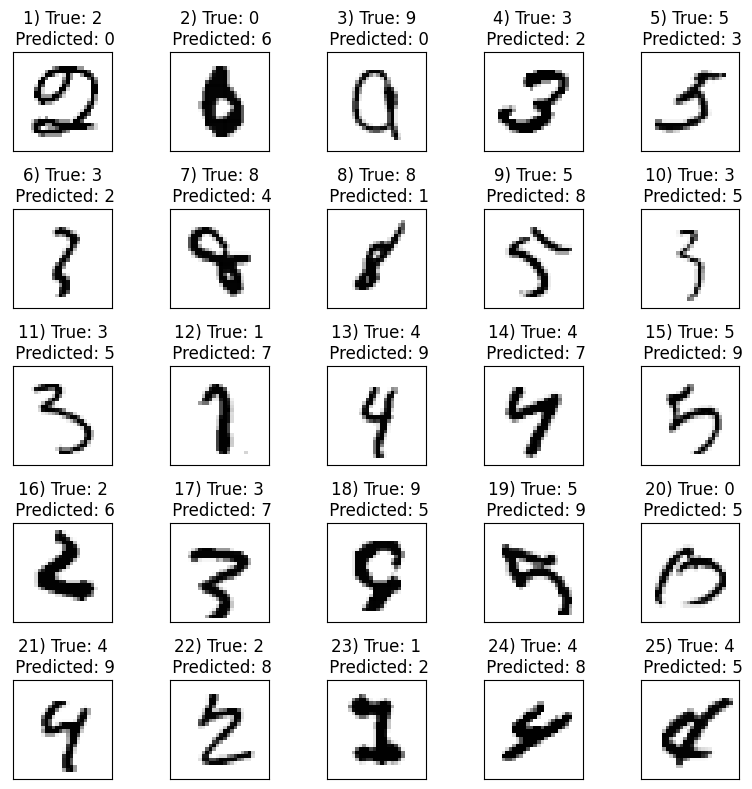

In [21]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
wandb.log({"Failure cases": plt})
plt.tight_layout()
plt.show()

confusion matrix

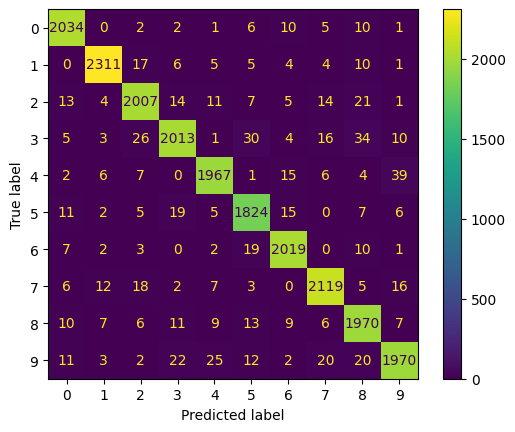

In [22]:
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
wandb.log({"Confusion matrix": plt})
plt.show()

## finish wandb

In [23]:
wandb.finish()

Test accuracy,96.35238
Test loss,0.19371
Train accuracy,97.2898
Train loss,0.16861
test accuracy,0.96352
test loss,0.19278


# eval MLP with 2 hidden layers

## train

In [24]:
run = wandb.init(
    project="HW3 part 1",
    name="2 layers MLP",
    config={
        "num_hidden": 500,
        "num_hidden2": 200})

In [25]:
model = NeuralNetMLP_2layers(num_features=28*28, num_hidden=500,
                             num_hidden2=200, num_classes=10)
model.fit(X_train, y_train, X_test, y_test)

Epoch: 001/050 | Train loss: 1.18 | Train accuracy: 79.96%  | Test loss: 1.19 | Test accuracy: 79.88%
Epoch: 002/050 | Train loss: 0.77 | Train accuracy: 86.17%  | Test loss: 0.78 | Test accuracy: 85.75%
Epoch: 003/050 | Train loss: 0.62 | Train accuracy: 88.33%  | Test loss: 0.62 | Test accuracy: 87.96%
Epoch: 004/050 | Train loss: 0.54 | Train accuracy: 89.53%  | Test loss: 0.54 | Test accuracy: 89.30%
Epoch: 005/050 | Train loss: 0.49 | Train accuracy: 90.27%  | Test loss: 0.49 | Test accuracy: 90.22%
Epoch: 006/050 | Train loss: 0.44 | Train accuracy: 90.64%  | Test loss: 0.45 | Test accuracy: 90.49%
Epoch: 007/050 | Train loss: 0.42 | Train accuracy: 91.31%  | Test loss: 0.43 | Test accuracy: 91.05%
Epoch: 008/050 | Train loss: 0.40 | Train accuracy: 91.57%  | Test loss: 0.41 | Test accuracy: 91.41%
Epoch: 009/050 | Train loss: 0.38 | Train accuracy: 91.86%  | Test loss: 0.39 | Test accuracy: 91.64%
Epoch: 010/050 | Train loss: 0.36 | Train accuracy: 92.13%  | Test loss: 0.37 | Te

NeuralNetMLP_2layers(num_classes=10, num_features=784, num_hidden=500,
                     num_hidden2=200)

In [26]:
plot_loss(model.epoch_train_loss)

In [27]:
plot_accuracy(model.epoch_train_acc)

## test

loss and acc

In [28]:
_, probas = model.forward(X_test)
log_test_loss_acc(y_test, probas)

test loss: 0.18
test accuracy: 96.20%


loss and acc graphs

In [29]:
plot_loss(model.epoch_test_loss, "Test")

In [30]:
plot_accuracy(model.epoch_test_acc, "Test")

OVR ROC curves

In [31]:
y_onehot_test = int_to_onehot(y_test, 10)
fig, ax = plt.subplots(figsize=(6, 6))
colors = cycle(["green", "yellow", "blue", "red", "black", "magenta", "orange",
                "chocolate", "purple", "gray"])
for class_id, color in zip(range(10), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id], probas[:, class_id],
        name=f"ROC curve for {class_id}", color=color, ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
wandb.log({"AUC graph for all classes": plt})

/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



plot failure cases

In [32]:
test_pred = np.argmax(probas, axis=1)
misclassified_images = X_test[y_test != test_pred][:25]
misclassified_labels = test_pred[y_test != test_pred][:25]
correct_labels = y_test[y_test != test_pred][:25]

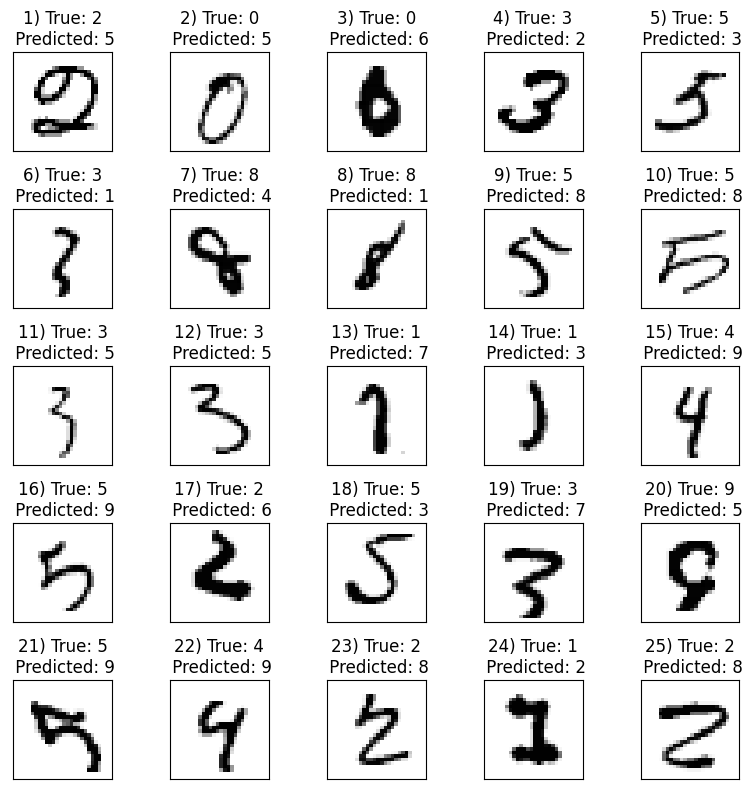

In [33]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
wandb.log({"Failure cases": plt})
plt.tight_layout()
plt.show()

confusion matrix

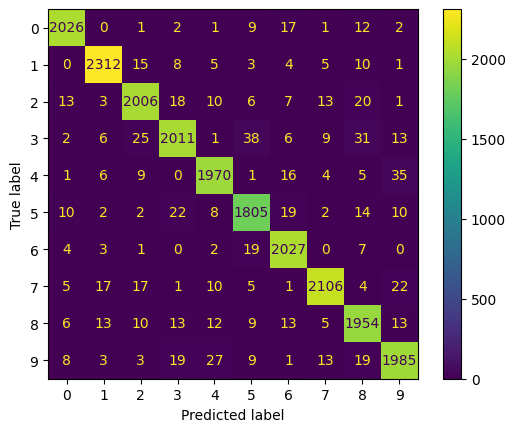

In [34]:
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
wandb.log({"Confusion matrix": plt})
plt.show()

## finish wandb

In [35]:
wandb.finish()

Test accuracy,96.2
Test loss,0.17942
Train accuracy,97.24082
Train loss,0.15282
test accuracy,0.962
test loss,0.17857


# eval keras ANN

## train

In [97]:
run = wandb.init(
    project="HW3 part 1",
    name="Fully connected ANN keras")

In [98]:
model = Sequential()
model.add(Dense(500, input_shape=((784,))))
model.add(Activation(activation='sigmoid'))
model.add(Dense(500))
model.add(Activation(activation='sigmoid'))
model.add(Dense(10))
model.add(Activation(activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 500)               392500    
                                                                 
 activation_12 (Activation)  (None, 500)               0         
                                                                 
 dense_13 (Dense)            (None, 500)               250500    
                                                                 
 activation_13 (Activation)  (None, 500)               0         
                                                                 
 dense_14 (Dense)            (None, 10)                5010      
                                                                 
 activation_14 (Activation)  (None, 10)                0         
                                                                 
Total params: 648,010
Trainable params: 648,010
Non-tr

In [99]:
class TestLossAcc(Callback):
  def __init__(self):
    self.epoch_test_loss = []
    self.epoch_test_acc = []

  def on_epoch_end(self, epoch, logs=None):
    probas = self.model.predict(X_test)
    onehot_y_test = int_to_onehot(y_test, num_labels=10)
    test_loss = categorical_crossentropy(onehot_y_test, probas).numpy().mean()
    self.epoch_test_loss.append(test_loss)

    test_pred = np.argmax(probas, axis=1)
    correct_pred = (test_pred == y_test).sum()
    test_acc = correct_pred/(y_test.shape[0])
    self.epoch_test_acc.append(test_acc)

In [100]:
test_loss_acc_callback = TestLossAcc()
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.1),
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [101]:
y_train_onehot = int_to_onehot(y_train, 10)
model.fit(X_train, y_train_onehot, batch_size=100, epochs=50,
          callbacks=test_loss_acc_callback)

Epoch 1/50
490/490 [==============================] - 10s 19ms/step - loss: 1.1047 - accuracy: 0.6689
Epoch 2/50
490/490 [==============================] - 10s 21ms/step - loss: 0.4124 - accuracy: 0.8827
Epoch 3/50
490/490 [==============================] - 8s 16ms/step - loss: 0.3426 - accuracy: 0.9013
Epoch 4/50
490/490 [==============================] - 9s 18ms/step - loss: 0.3115 - accuracy: 0.9099
Epoch 5/50
490/490 [==============================] - 8s 16ms/step - loss: 0.2887 - accuracy: 0.9158
Epoch 6/50
490/490 [==============================] - 9s 18ms/step - loss: 0.2715 - accuracy: 0.9206
Epoch 7/50
490/490 [==============================] - 9s 18ms/step - loss: 0.2543 - accuracy: 0.9259
Epoch 8/50
490/490 [==============================] - 7s 15ms/step - loss: 0.2383 - accuracy: 0.9305
Epoch 9/50
490/490 [==============================] - 9s 18ms/step - loss: 0.2245 - accuracy: 0.9345
Epoch 10/50
490/490 [==============================] - 10s 21ms/step - loss: 0.2097 - acc

In [102]:
plot_loss(model.history.history['loss'])

In [103]:
plot_accuracy(model.history.history['accuracy'])

## test

loss and acc

In [104]:
probas = model.predict(X_test)
log_test_loss_acc(y_test, probas)

657/657 [==============================] - 2s 3ms/step
test loss: 0.09
test accuracy: 97.34%


loss and acc graphs

In [105]:
plot_loss(test_loss_acc_callback.epoch_test_loss, "Test")

In [106]:
plot_accuracy(test_loss_acc_callback.epoch_test_acc, "Test")

OVR ROC curves

In [107]:
onehot_y_test = int_to_onehot(y_test, num_labels=10)
fig, ax = plt.subplots(figsize=(6, 6))
colors = cycle(["green", "yellow", "blue", "red", "black", "magenta", "orange",
                "chocolate", "purple", "gray"])
for class_id, color in zip(range(10), colors):
    RocCurveDisplay.from_predictions(
        onehot_y_test[:, class_id], probas[:, class_id],
        name=f"ROC curve for {class_id}", color=color, ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
wandb.log({"AUC graph for all classes": plt})

/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



plot failure cases

In [108]:
test_pred = np.argmax(probas, axis=1)
misclassified_images = X_test[y_test != test_pred][:25]
misclassified_labels = test_pred[y_test != test_pred][:25]
correct_labels = y_test[y_test != test_pred][:25]

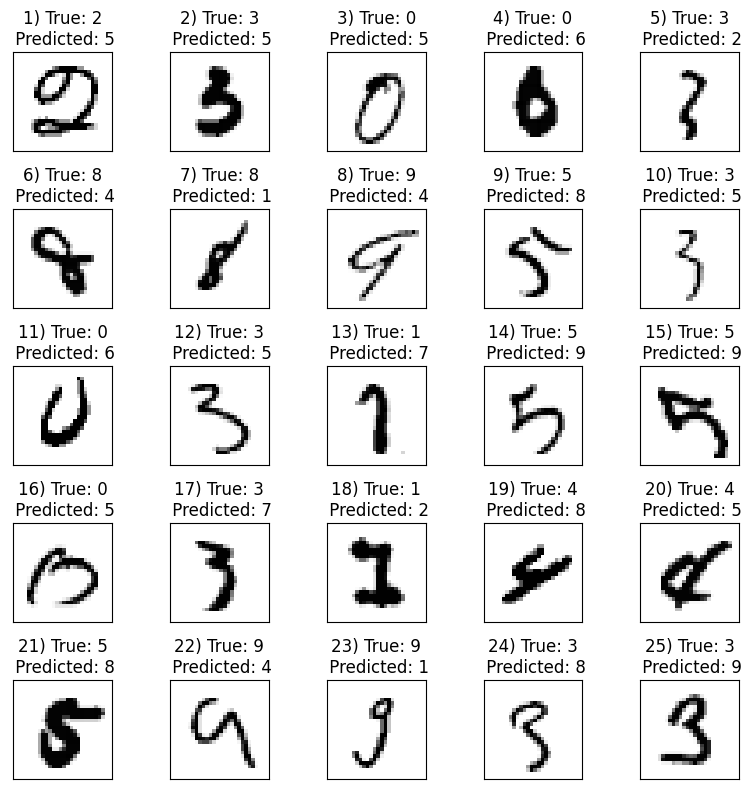

In [109]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
wandb.log({"Failure cases": plt})
plt.tight_layout()
plt.show()

confusion matrix

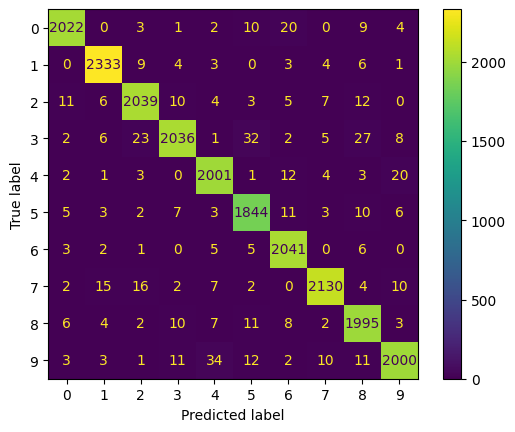

In [110]:
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
wandb.log({"Confusion matrix": plt})
plt.show()

## finish wandb

In [111]:
wandb.finish()

Test accuracy,0.97338
Test loss,0.08554
Train accuracy,0.99063
Train loss,0.03508
test accuracy,0.97338
test loss,0.08554
